In [1]:
import pyemma.coordinates as coords
import pyemma.plots as mplt
import pyemma
import msmtools
import h5py
import mdtraj as md
import msmtools.estimation as est
import numpy as np
import pickle
import sklearn
import pyclustering
import matplotlib.pyplot as plt
import sklearn.cluster as skc
import MSMRD.trajectories.trajectoryTools as trajectoryTools
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
f = h5py.File('/srv/public/data/dibakma/MSMRD/myoglobin/tmp/CO_trajectories_aligned.h5')
fCA = h5py.File('/srv/public/data/dibakma/MSMRD/myoglobin/tmp/CA_trajectories_aligned.h5')
fHEM = h5py.File('/srv/public/data/dibakma/MSMRD/myoglobin/tmp/HEM_trajectories_aligned.h5')
trajs = 10.*np.array(f['coordinates']) #factor of ten to convert from nm to angstroem
trajsCA = 10.*np.array(fCA['coordinates'])
trajsHEM = 10.*np.array(fHEM['coordinates'])
f.close()
fCA.close()
fHEM.close()

In [3]:
data = [trajs[:,i,:] for i in range(20)]

In [4]:
#determine center of mass of the myoglobin CA atoms
com = np.mean(np.mean(trajsCA, axis=0), axis=0)
print com

[ 24.95029831  24.45178986  25.39104462]


In [5]:
#determine radius of myoglobine in order to estimate MSM radius
CAradius = np.amax(np.linalg.norm(trajsCA-com, axis=2))

In [6]:
outsideIndices = []
for i in range(20):
    outsideIndices.append(np.where(np.linalg.norm(trajs[:,i,:] - com, axis=1) > CAradius)[0])

In [7]:
splitArrays = np.array_split(trajs[:,0,:], outsideIndices[0])

In [8]:
outerTrajs = []
trajActive = False
innerTrajActive = False
for traj in data:
    norm = np.linalg.norm(traj - com, axis = 1)
    trajActive = False
    innerTrajActive = False
    length = len(traj)
    for i in range(0, length):
        if not trajActive:
            if norm[i]>CAradius:
                #Start a new truncated trajectory. Maybe add previous state!
                trajActive = True
                if i > 0:
                    currentTraj = [traj[i-1], traj[i]]
                else:
                    currentTraj = [traj[i]]
        else:
            if norm[i] < CAradius:
                trajActive = False
                currentTraj.append(traj[i])
                outerTrajs.append(np.array(currentTraj))
            else:
                currentTraj.append(traj[i])

In [75]:
times = range(1, 100 , 5)
SDs = []
for time in times:
    SDs.append([])
    for outerTraj in outerTrajs:
        length = len(outerTraj)
        squaredDisplacements = []
        for i in range(length-time):
            displacement = np.power(np.linalg.norm(outerTraj[i+time] - outerTraj[i]),2)
            if displacement < 1000: # look at max displacement of half a box length
                SDs[-1].append(np.power(np.linalg.norm(outerTraj[i+time] - outerTraj[i]),2))

In [76]:
MSDs = np.array([np.mean(SD) for SD in SDs])
STDs = np.array([np.std(SD)/np.sqrt(float(len(SD))) for SD in SDs])
times = np.array(times)

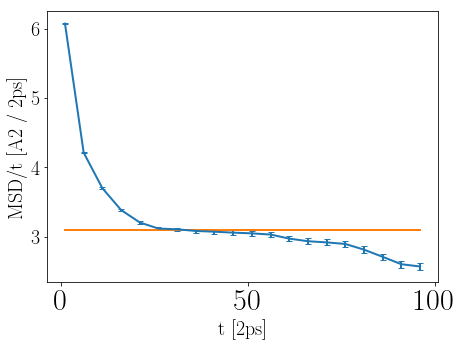

In [78]:
plt.style.use('paperPlot')
plt.errorbar(times, MSDs/(times), yerr=2.*STDs/times)
#approximately linear around 25-75 ps
plt.plot(times, [3.09]*len(times))
plt.xlabel('t [2ps]')
plt.ylabel('MSD/t [A2 / 2ps]')
#plt.ylim((0,30))

In [40]:
D = 3.1/6
# fits alright witht the experimental value of 0.203 A^2/ps
print D # A^2/2ps
print D/2 # A^2/ps

0.516666666667
0.258333333333


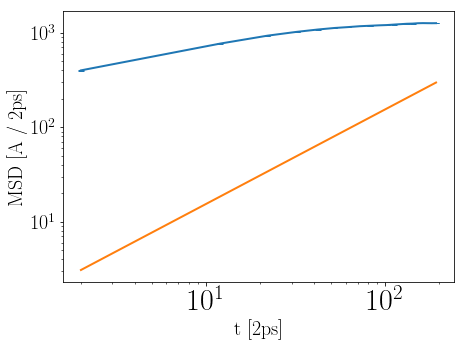

In [50]:
plt.errorbar(2*times, MSDs, yerr=2*STDs)
plt.plot(2*times, times*6*0.258*2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('t [2ps]')
plt.ylabel('MSD [A / 2ps]')

0.5
0.25
